## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
sns.set(style="white")

%matplotlib inline

def heatmap(data, *cols, target, xtick=None, ytick=None, annot=True, fmt='.2f', figsize=None):
    import seaborn as sns
    from matplotlib import pyplot as plt

    figsize = figsize or (16, 4)
    f, axs = plt.subplots(1, 2, figsize=figsize)

    def draw(chop, axis):
        pivot_params = list(cols) + [target]
        g = chop.groupby(list(cols))[target]
        mean_ = g.mean().reset_index().pivot(*pivot_params)
        count_ = g.size().reset_index().pivot(*pivot_params)
        if xtick is not None or ytick is not None:
            mean_ = mean_.reindex(index=ytick, columns=xtick)
            count_ = count_.reindex(index=ytick, columns=xtick)

        sns.heatmap(mean_.fillna(0), annot=annot, ax=axis[0], fmt=fmt, cmap="YlGnBu")
        sns.heatmap(count_.fillna(0), annot=annot, ax=axis[1], fmt=fmt, cmap="YlGnBu")
        axis[0].set_title('mean')
        axis[1].set_title('count')

    draw(data, axs)
    plt.show()
    
def chi_square(x, y, data, verbose=True):
    """
    Return: True if x is dependet with y else False
    """
    table = data.groupby([x, y]).size().reset_index(name='size')
    pivot = table.pivot(index=x, columns=y, values='size').fillna(0.)
    
    # Calculate chi-square value, p-value, degree of freedom, expected value
    chi, pv, df, expected = stats.chi2_contingency(observed=pivot.values)
    # check if chi-square value > criterion(95% confidence interval)
    crit = stats.chi2.ppf(q=0.95, df=df)
    if verbose:
        print(pivot)
        print()
        print(expected)
        print()
        print(f'chi-square value: {chi}, criterion: {crit}')
    return chi > crit

def anova(formula, data, verbose=True):
    table  = sm.stats.anova_lm(
        ols(formula, data=data).fit(), 
        typ=2)
    return table

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Purpose: 根據Company歷史紀錄, 判斷該Company是否已出現財務危機?


## Data Schema

Column name     | Description
             ---|---
Company       |    Company ID
Time          |    Order by each company
x1 ~ x83      |    Unknown continuous variables
x80           |    Unknown categorical variables
distress_num  |    Continuous label
distress_catg |    Categorical label

---
* 1個類別變數(去除`Company Time`)
* 82個類別變數
---



# EDA(Exploratory Data Analysis)
* `distress_num`是原始Label欄位
    * `distress_num <= -0.5` => 有財務危機
    * `distress_num >  -0.5` => 財務狀態健康
    
* `distress_catg`
    * `distress_num <= -0.5` => 1
    * `distress_num > -0.5`  => 0
* Label = `distress_catg` => Classification Problem


In [2]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_distress.csv")
raw.head()

,Company,Time,distress_num,x1,x2,x3,x4,x5,x6,x7,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,distress_catg
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49,0
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50,0
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51,0
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52,1
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27,0


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 87 columns):
Company          2557 non-null int64
Time             2557 non-null int64
distress_num     2557 non-null float64
x1               2557 non-null float64
x2               2557 non-null float64
x3               2557 non-null float64
x4               2557 non-null float64
x5               2557 non-null float64
x6               2557 non-null float64
x7               2557 non-null float64
x8               2557 non-null float64
x9               2557 non-null float64
x10              2557 non-null float64
x11              2557 non-null float64
x12              2557 non-null float64
x13              2557 non-null float64
x14              2557 non-null float64
x15              2557 non-null float64
x16              2557 non-null float64
x17              2557 non-null float64
x18              2557 non-null float64
x19              2557 non-null float64
x20              2557 non-null float64


## Observe the label distribution

0    2504
1      53
Name: distress_catg, dtype: int64



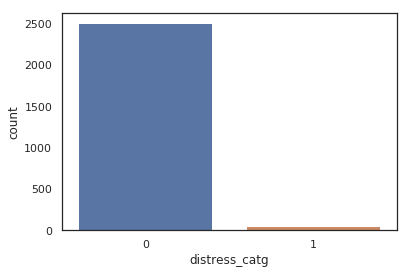

In [4]:
print( raw.distress_catg.value_counts() )
print()
sns.countplot(x='distress_catg', data=raw)

## Observation

* Not Churn : Churn 的數量大約是 1 : 47 左右, 是所謂imbalanced dataset, 通常我們關心的都是少數族群(Minority)

---

<br/>
<br/>
<br/>

## Feature Settings

In [5]:
catg_features = ['x80']
num_features = [f'x{i}' for i in range(1, 84) if i != 80]
print('Categorical: ', catg_features)
print('Numerical: ', num_features)

Categorical:  ['x80']
Numerical:  ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x81', 'x82', 'x83']


# 多變數分析: Categorical x Categorical

---



## 類別變數的 Correlation Heatmap

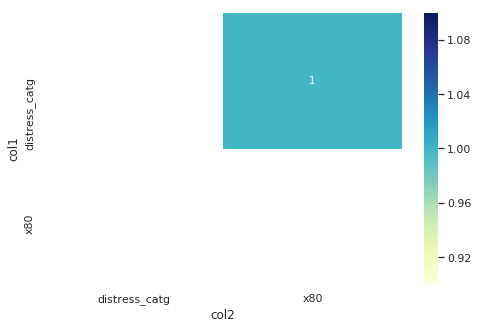

In [6]:
def catg_corr(catg_cols, data):
    corr = []
    for i, x in enumerate(catg_cols):
        corr += [(x, x, 1)]
        for y in catg_cols[i+1:]:
            r = int(chi_square(x, y, data, verbose=False))
            corr += [(x, y, r), (y, x, r)]
            
    corr = pd.DataFrame(data=corr, columns=['col1', 'col2', 'val'])\
             .pivot('col1', 'col2', 'val')
    return corr

corr = catg_corr(catg_features + ['distress_catg'], raw)
plt.figure(figsize=(8, 5))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr, cmap="YlGnBu", mask=mask, annot=True)

## (LAB) Call chi_square Function 檢視 x80, distress_catg 的卡方分配統計量與Criterion

In [0]:
# chi_square(...)

## Observations
* `x80`是顯著Feature

<br/>
<br/>
<br/>

---

# 多變數分析: Categorical x Numeric


## x80 cross x1: Violin Plot, Distribute Plot
* 畫Countplot觀察數量分布

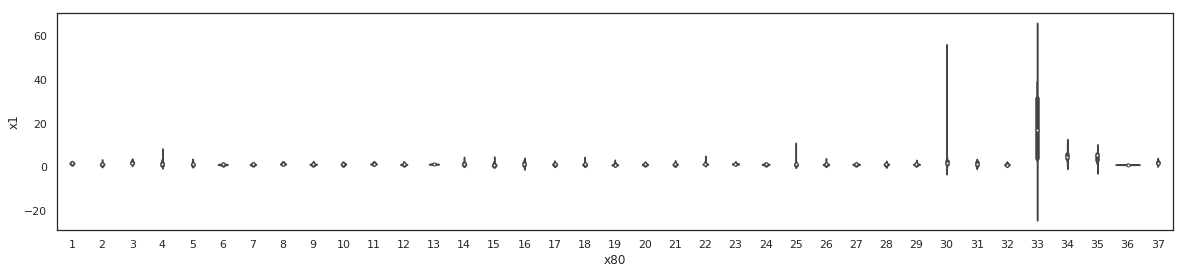

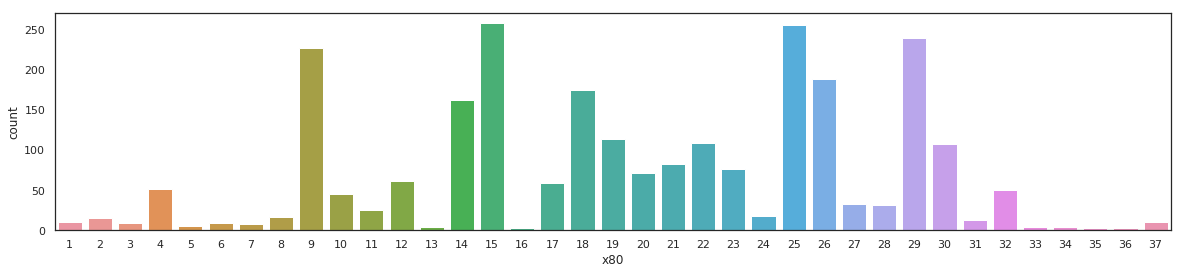

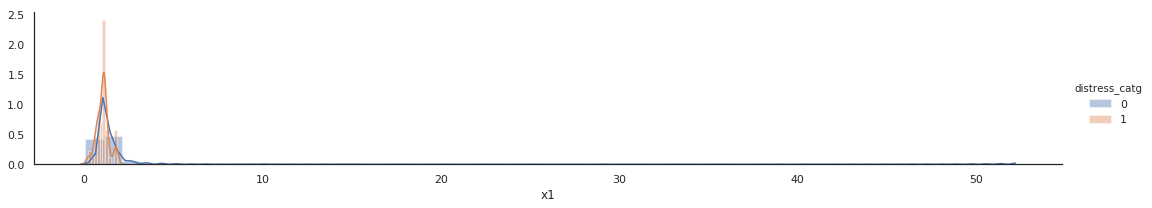

In [7]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x1')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x1').add_legend()

In [8]:
anova('x1 ~ C(x80)', raw)

,sum_sq,df,F,PR(>F)
C(x80),1695.328153,36.0,22.697688,1.426743e-126
Residual,5228.416599,2520.0,NaN,NaN


In [9]:
anova('x1 ~ C(distress_catg)', raw)

,sum_sq,df,F,PR(>F)
C(distress_catg),5.593283,1.0,2.065702,0.150768
Residual,6918.151469,2555.0,NaN,NaN


## x80 cross x2: Violin Plot, Distribute Plot

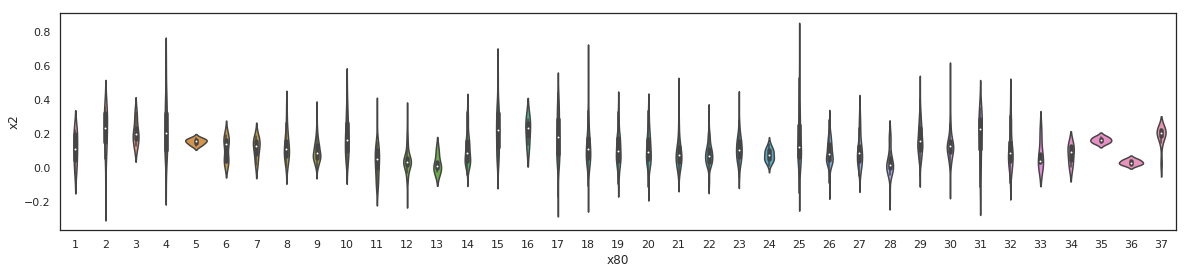

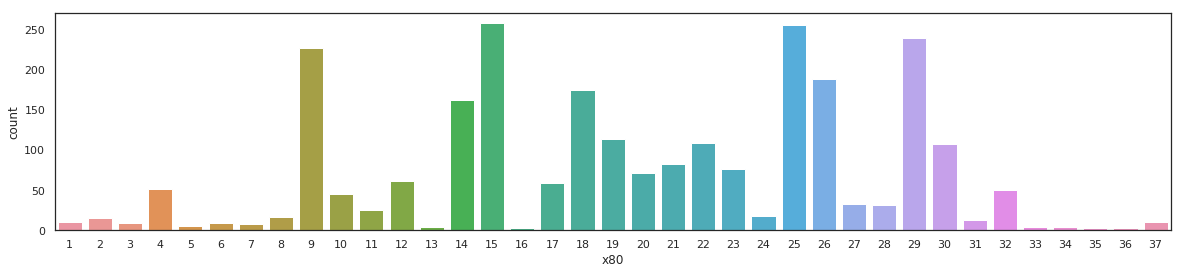

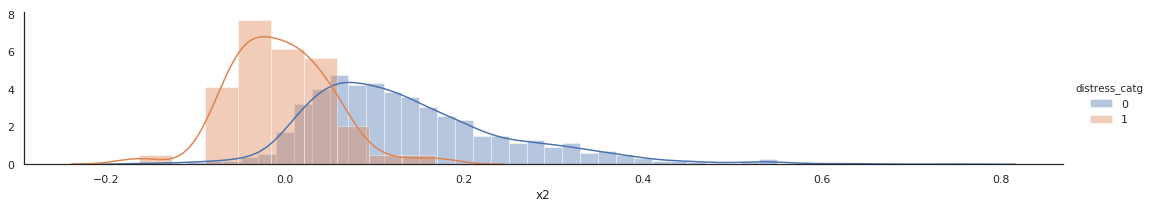

In [15]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x2')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x2').add_legend()

In [16]:
anova('x2 ~ C(x80)', raw)

,sum_sq,df,F,PR(>F)
C(x80),6.322043,36.0,15.61113,3.202652e-85
Residual,28.347917,2520.0,NaN,NaN


In [17]:
anova('x2 ~ C(distress_catg)', raw)

,sum_sq,df,F,PR(>F)
C(distress_catg),1.090218,1.0,82.951995,1.651089e-19
Residual,33.579743,2555.0,NaN,NaN


## (LAB) x80 cross x3: 檢視x80, x3是否有關係, x3 feature是否顯著
* Violin Plot, Countplot, Distribute Plot

In [0]:
# 修改問號部分
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='???')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, '???').add_legend()

In [0]:
anova('???', raw)

In [0]:
anova('???', raw)

## (LAB) x80 cross x4: 檢視 x80, x4是否有關係, x4 feature是否顯著
* Violin Plot, Countplot, Distribute Plot

In [0]:
# 修改問號部分
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='???')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, '???').add_legend()

In [0]:
# anova('???', raw)

In [0]:
# anova('???', raw)

## (LAB) 在 x10 ~ x79當中挑選出兩個, 檢視是否與 x80 有關係, 且檢視該Feature是否顯著
* 這裡只有畫出 Violin plot, Distribution plot

In [0]:
# 修改問號部分
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='???')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, '???').add_legend()
print(anova('???', raw), '\n')
print(anova('???', raw))

In [0]:
# 修改問號部分
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='???')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, '???').add_legend()
print(anova('???', raw), '\n')
print(anova('???', raw))

## Observation
* `x80, x1`: 有非線性關係
* `x80, x2`: 有非線性關係, `x2`是顯著feature
* `x80, x3`: 有非線性關係, `x3`是顯著feature
* `x80, x4`: 有非線性關係

---

* `x80, x48`: 有非線性關係, `x48`是顯著feature
* `x80, x79`: 有非線性關係, `x79`是顯著feature



<br/>
<br/>
<br/>

---


# 多變數分析: Numeric x Numeric

## Correlation: Pearson, Spearman
- Pearson: 變數最好遵從常態分配, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})} {\sqrt{\sum(x_i - \bar{x}^2 )}\sqrt{\sum(y_i - \bar{y}^2)}} $$

---

- Spearman: 只注重排序關係, numeric, ordinal變數都可以接受, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = 1 - \frac{6  \sum d_i^2} {n(n^2 - 1)} $$

- 這裡只看pearson相關係數

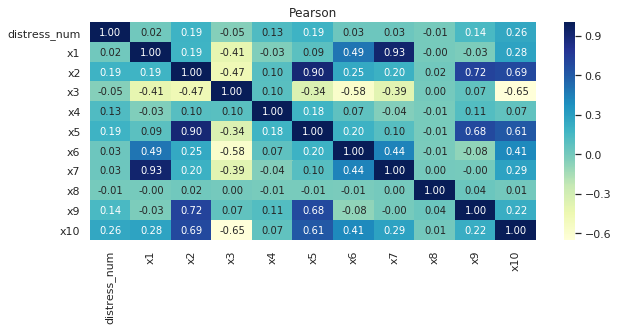

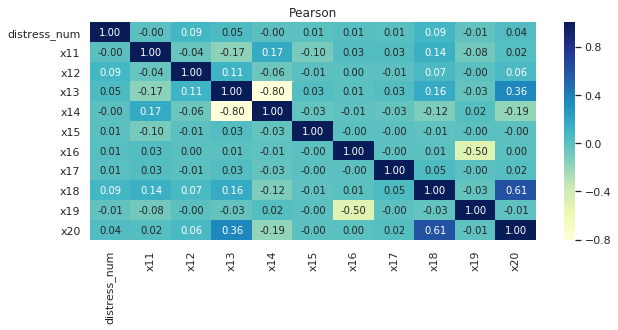

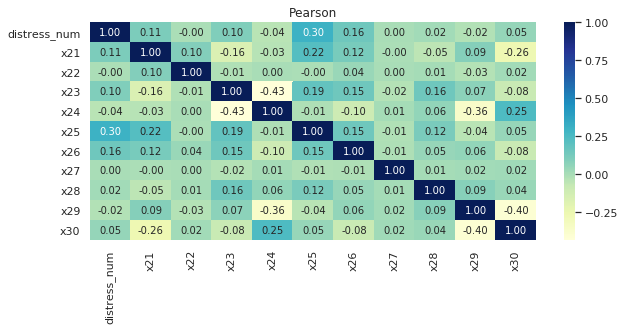

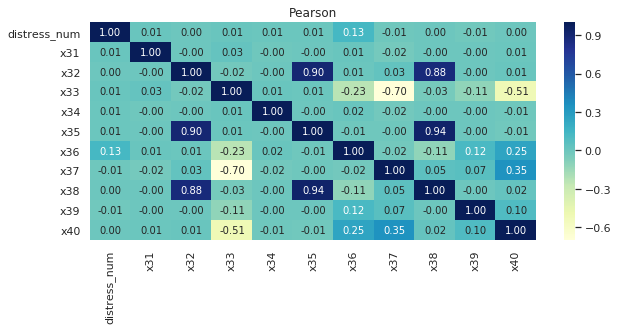

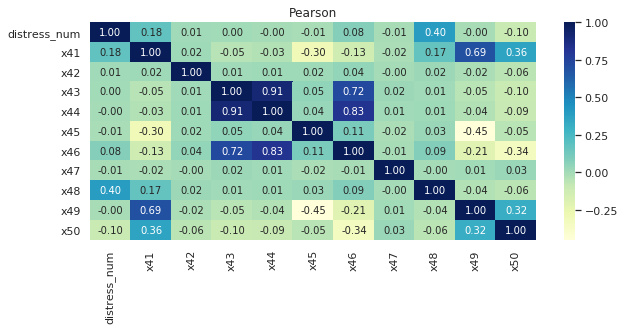

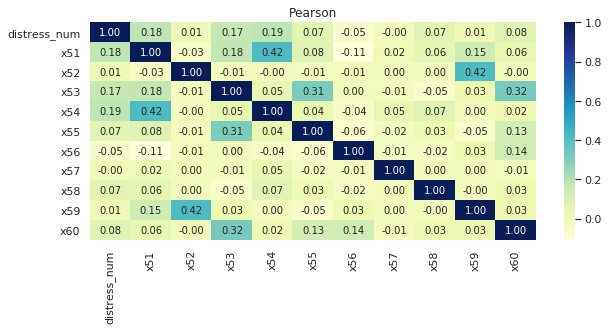

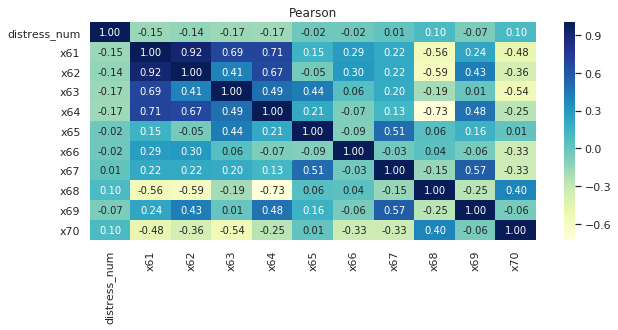

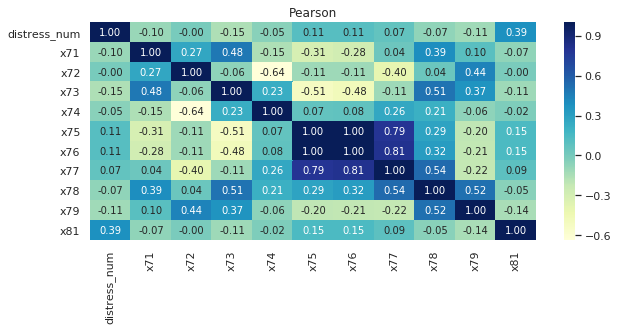

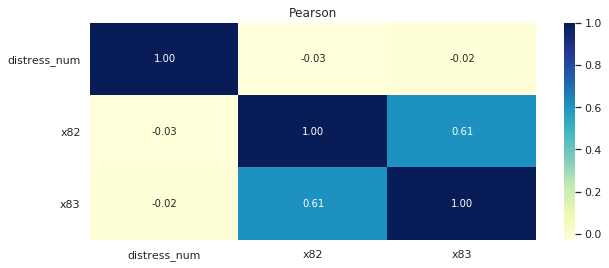

In [18]:
n_batch = 10
for cut_pos in np.arange(0, len(num_features), n_batch):
    plt.figure(figsize=(10, 4))
    batch_cols = ['distress_num'] + num_features[cut_pos:cut_pos + n_batch]
    sns.heatmap(raw[batch_cols].corr(), annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Pearson')
    plt.show()

## 連續變數與Label(distress_catg)的關係

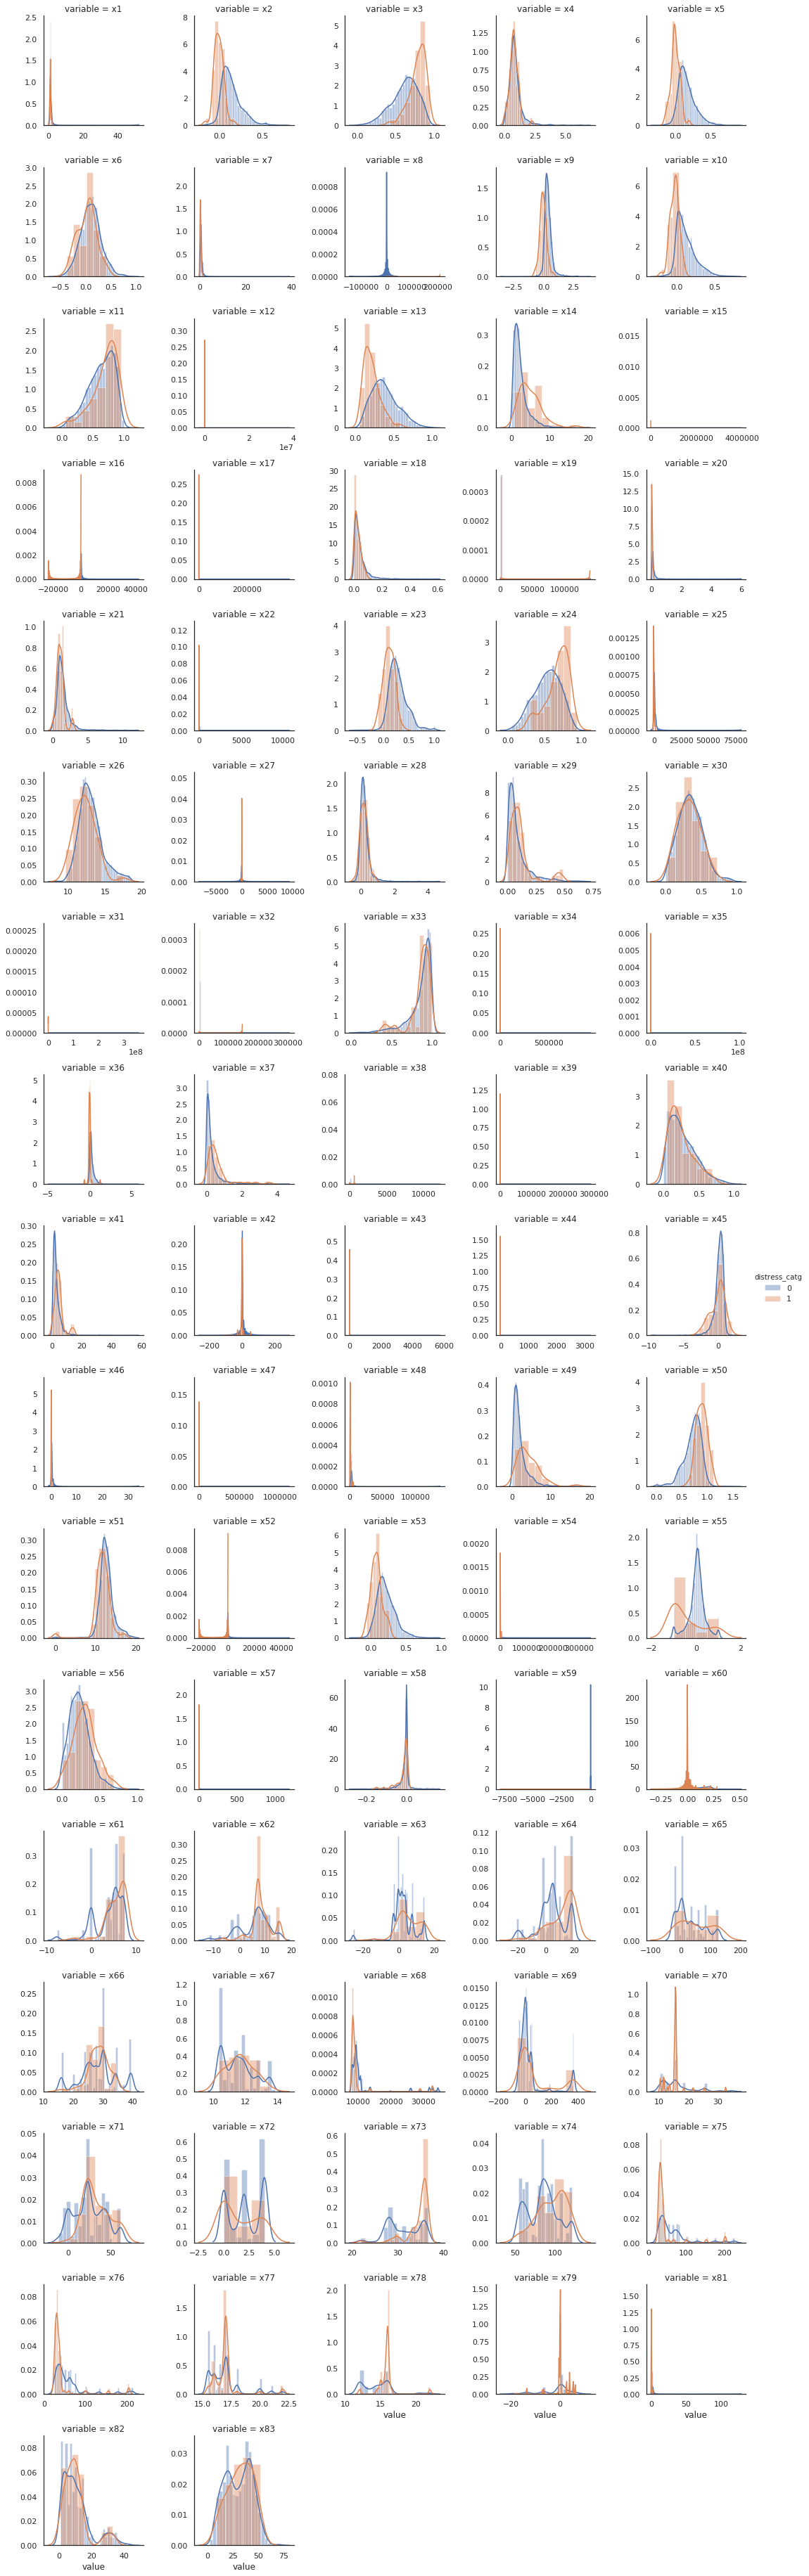

In [20]:
tmp = pd.melt(raw[num_features])
tmp['distress_catg'] = raw.distress_catg.tolist() * len(num_features)
ax = sns.FacetGrid(col='variable', sharex=False, sharey=False,
              hue='distress_catg',
              data=tmp,
              col_wrap=5).map(sns.distplot, 'value').add_legend()

## (LAB) Loop所有連續變數, 算出ANOVA table (與Label distress_catg), 抓出PR(>F)檢測是否小於0.05(顯著)

In [0]:
# for num_feat in num_features:
#     table = anova(f'{num_feat} ~ C(distress_catg)', data=raw)
#     ...

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

### Solution 

In [0]:
# tmp = pd.Series(
#     dict((num_feat, anova(f'{num_feat} ~ C(distress_catg)', data=raw)['PR(>F)'].values[0])
#          for num_feat in num_features)
# )
# significant_feats = tmp[tmp < 0.05].index
# print('Significant numeric features', significant_feats)

# Conclusion

* 數值變數`x1 ~ x83` (除`x80`)有一半以上顯著的變數, 當中有眾多互相的線性正相關與負相關
* 類別變數`x80`是顯著變數
